In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor # Example models
from sklearn.metrics import accuracy_score, r2_score # Example metrics


In [ ]:
def calculate_feature_importance_shuffle(model, X, y, metric, feature_names=None, n_repeats=5):
    """
    Calculates feature importance using the Shuffle Feature Importance technique.

    Args:
        model: Trained machine learning model (must have a predict method).
        X: Feature matrix (pandas DataFrame or numpy array).
        y: Target variable (pandas Series or numpy array).
        metric: Metric function to evaluate model performance (e.g., accuracy_score, r2_score).
        feature_names: List of feature names (optional, used for output).
        n_repeats: Number of times to shuffle each feature to average the performance drop.

    Returns:
        pandas.Series: Feature importances, indexed by feature name, sorted in descending order.
    """

    if not isinstance(X, pd.DataFrame):
        X = pd.DataFrame(X)  # Convert to DataFrame if it's a numpy array
    if feature_names is None:
        feature_names = X.columns.tolist()

    baseline_performance = metric(y, model.predict(X))
    feature_importances = {}

    for feature in feature_names:
        importance_scores = []
        for _ in range(n_repeats):
            X_shuffled = X.copy()
            X_shuffled[feature] = np.random.permutation(X_shuffled[feature].values) # Shuffle one feature column
            shuffled_performance = metric(y, model.predict(X_shuffled))
            performance_drop = baseline_performance - shuffled_performance
            importance_scores.append(performance_drop)

        feature_importances[feature] = np.mean(importance_scores) # Average performance drop

    importance_series = pd.Series(feature_importances, name='importance').sort_values(ascending=False)
    return importance_series

In [ ]:
if __name__ == '__main__':
    # Example Usage with a Classification Model (RandomForestClassifier) and Iris Dataset
    from sklearn.datasets import load_iris
    iris = load_iris()
    X_iris, y_iris = iris.data, iris.target
    feature_names_iris = iris.feature_names

    X_train_iris, X_test_iris, y_train_iris, y_test_iris = train_test_split(X_iris, y_iris, test_size=0.3, random_state=42)
    model_iris = RandomForestClassifier(random_state=42)
    model_iris.fit(X_train_iris, y_train_iris)

    importance_iris = calculate_feature_importance_shuffle(
        model_iris,
        pd.DataFrame(X_test_iris, columns=feature_names_iris), # Pass as DataFrame with feature names
        y_test_iris,
        accuracy_score,
        feature_names=feature_names_iris,
        n_repeats=10 # Increased repeats for more robust estimate
    )

    print("Feature Importances for Iris Dataset (Classification):\n", importance_iris)


    # Example Usage with a Regression Model (RandomForestRegressor) and a synthetic dataset
    from sklearn.datasets import make_regression
    X_reg, y_reg = make_regression(n_samples=100, n_features=5, noise=0.1, random_state=42)
    feature_names_reg = [f'feature_{i+1}' for i in range(X_reg.shape[1])]

    X_train_reg, X_test_reg, y_train_reg, y_test_reg = train_test_split(X_reg, y_reg, test_size=0.3, random_state=42)
    model_reg = RandomForestRegressor(random_state=42)
    model_reg.fit(X_train_reg, y_train_reg)

    importance_reg = calculate_feature_importance_shuffle(
        model_reg,
        pd.DataFrame(X_test_reg, columns=feature_names_reg), # Pass as DataFrame with feature names
        y_test_reg,
        r2_score,
        feature_names=feature_names_reg,
        n_repeats=10 # Increased repeats for more robust estimate
    )

    print("\nFeature Importances for Regression Dataset:\n", importance_reg)

Dataset loaded successfully. Shape: (2511, 7)

Cross-validation scores: [0.99866261 0.99823095 0.99871184 0.99839147 0.99900466]
Average CV score: 0.9986 (+/- 0.0005)

Model Performance Metrics:
R² Score: 0.9989
MSE: 95.1211
RMSE: 9.7530
MAE: 6.9711


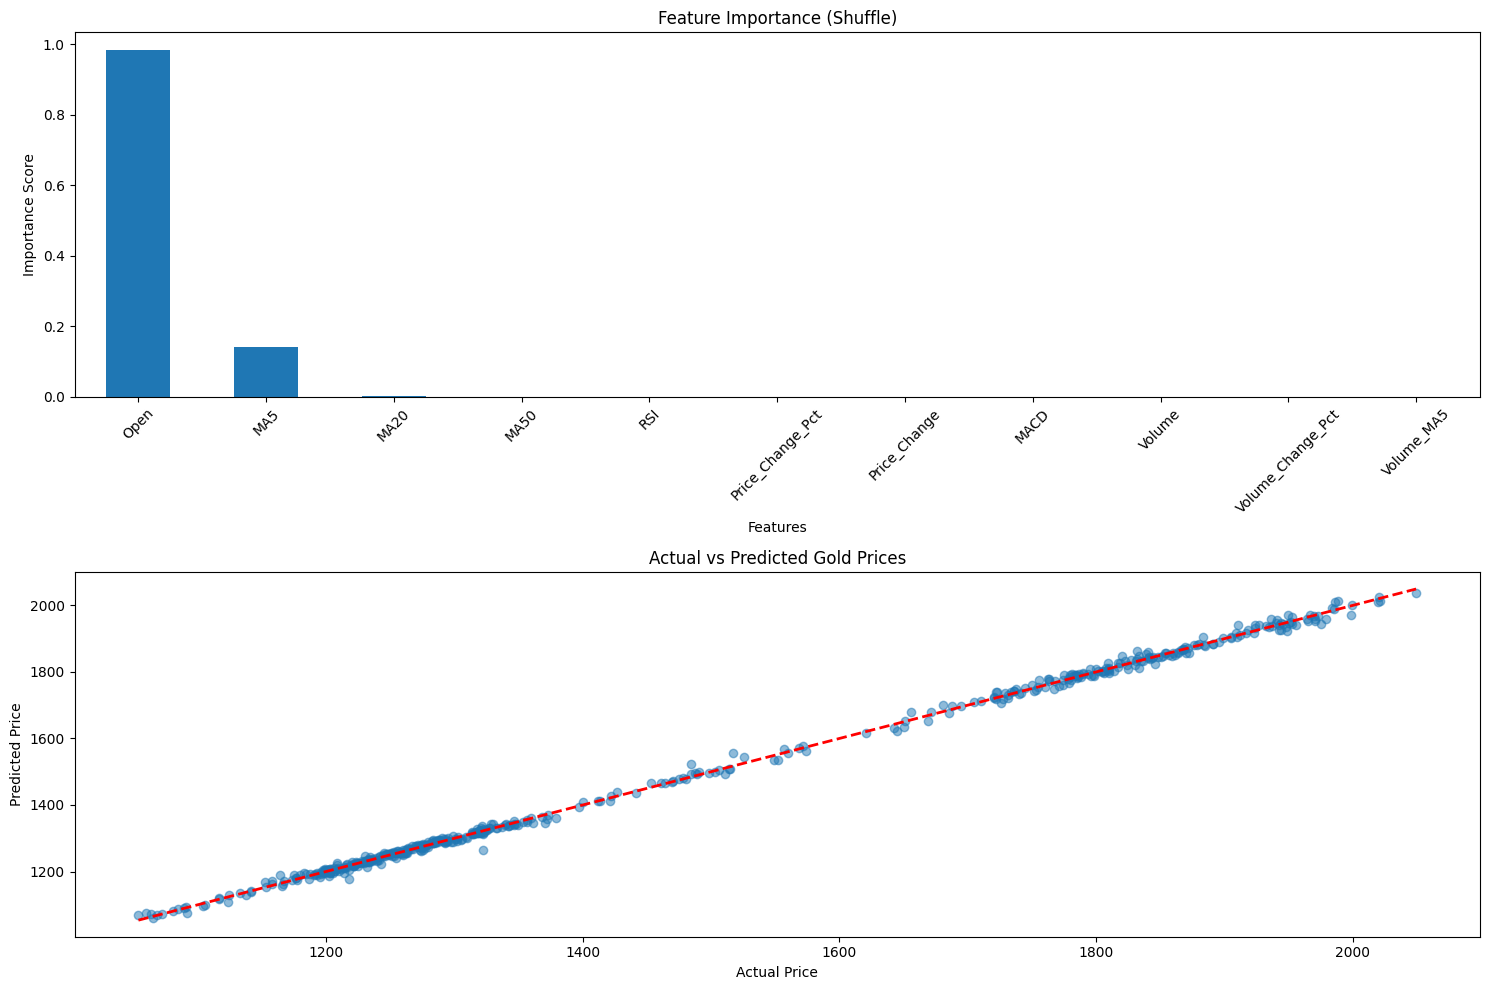

In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings('ignore')

def add_technical_indicators(df):
    """Add technical indicators for gold price analysis"""
    # Price-based indicators
    df['Price_Change'] = df['Close'].diff()
    df['Price_Change_Pct'] = df['Close'].pct_change()
    
    # Volume indicators
    df['Volume_Change_Pct'] = df['Volume'].pct_change()
    df['Volume_MA5'] = df['Volume'].rolling(window=5).mean()
    
    # Moving averages
    df['MA5'] = df['Close'].rolling(window=5).mean()
    df['MA20'] = df['Close'].rolling(window=20).mean()
    df['MA50'] = df['Close'].rolling(window=50).mean()
    
    # Technical indicators
    df['RSI'] = calculate_rsi(df['Close'], periods=14)
    df['MACD'] = calculate_macd(df['Close'])
    
    return df

def calculate_rsi(prices, periods=14):
    """Calculate Relative Strength Index"""
    delta = prices.diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=periods).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=periods).mean()
    rs = gain / loss
    return 100 - (100 / (1 + rs))

def calculate_macd(prices, slow=26, fast=12):
    """Calculate MACD (Moving Average Convergence Divergence)"""
    exp1 = prices.ewm(span=fast).mean()
    exp2 = prices.ewm(span=slow).mean()
    return exp1 - exp2

def evaluate_model(model, X_test, y_test):
    """Evaluate model performance using multiple metrics"""
    y_pred = model.predict(X_test)
    metrics = {
        'R² Score': r2_score(y_test, y_pred),
        'MSE': mean_squared_error(y_test, y_pred),
        'RMSE': np.sqrt(mean_squared_error(y_test, y_pred)),
        'MAE': mean_absolute_error(y_test, y_pred)
    }
    return metrics, y_pred

if __name__ == '__main__':
    # Data loading and preprocessing
    try:
        veri = pd.read_csv('goldstock.csv')
        print(f"Dataset loaded successfully. Shape: {veri.shape}")
    except FileNotFoundError:
        print("Error: goldstock.csv file not found in the current directory")
        exit(1)

    # Convert Date and add technical indicators
    veri['Date'] = pd.to_datetime(veri['Date'])
    veri = add_technical_indicators(veri)
    
    # Remove highly correlated features and handle missing values
    features_to_drop = ['Date', 'High', 'Low', 'Unnamed: 0']
    veri = veri.drop(features_to_drop, axis=1)
    veri = veri.dropna()
    
    # Feature scaling
    scaler = StandardScaler()
    features = veri.drop('Close', axis=1)
    features_scaled = pd.DataFrame(scaler.fit_transform(features), columns=features.columns)
    
    # Train-test split
    X_train, X_test, y_train, y_test = train_test_split(
        features_scaled, veri['Close'], 
        test_size=0.2, 
        random_state=42
    )

    # Model training with optimized parameters
    model = RandomForestRegressor(
        n_estimators=250,
        max_depth=10,
        min_samples_split=5,
        random_state=42,
        n_jobs=-1  # Use all available cores
    )

    # Cross-validation
    cv_scores = cross_val_score(model, X_train, y_train, cv=5)
    print(f"\nCross-validation scores: {cv_scores}")
    print(f"Average CV score: {cv_scores.mean():.4f} (+/- {cv_scores.std() * 2:.4f})")

    # Train final model
    model.fit(X_train, y_train)

    # Calculate feature importance
    importance_scores = calculate_feature_importance_shuffle(
        model,
        X_test,
        y_test,
        r2_score,
        feature_names=features.columns.tolist(),
        n_repeats=10
    )

    # Evaluate model
    metrics, y_pred = evaluate_model(model, X_test, y_test)
    print("\nModel Performance Metrics:")
    for metric, value in metrics.items():
        print(f"{metric}: {value:.4f}")

    # Visualizations
    plt.figure(figsize=(15, 10))

    # Feature importance plot
    plt.subplot(2, 1, 1)
    importance_scores.plot(kind='bar')
    plt.title('Feature Importance (Shuffle)')
    plt.xlabel('Features')
    plt.ylabel('Importance Score')
    plt.xticks(rotation=45)

    # Actual vs Predicted plot
    plt.subplot(2, 1, 2)
    plt.scatter(y_test, y_pred, alpha=0.5)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
    plt.xlabel('Actual Price')
    plt.ylabel('Predicted Price')
    plt.title('Actual vs Predicted Gold Prices')

    plt.tight_layout()
    plt.show()

    # Save results
    results = pd.DataFrame({
        'Actual': y_test,
        'Predicted': y_pred
    })
    results.to_csv('gold_price_predictions.csv')

In [ ]:
def check_overfitting(train_score, test_score, threshold=0.1):
    """
    Check if model is overfitting by comparing training and test scores
    
    Args:
        train_score (float): Score on training data
        test_score (float): Score on test data
        threshold (float): Maximum acceptable difference between scores
        
    Returns:
        bool: True if overfitting detected, False otherwise
        str: Message explaining the result
    """
    difference = abs(train_score - test_score)
    is_overfitting = difference > threshold
    
    message = f"""
    Training Score: {train_score:.4f}
    Test Score: {test_score:.4f}
    Difference: {difference:.4f}
    Status: {'Overfitting detected' if is_overfitting else 'No overfitting detected'}
    """
    
    return is_overfitting, message

def prevent_overfitting(model, X_train, y_train, X_test, y_test):
    """
    Implement techniques to prevent overfitting
    """
    from sklearn.model_selection import GridSearchCV
    
    param_grid = {
        'n_estimators': [100, 200, 300],
        'max_depth': [5, 10, 15, None],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4]
    }
    
    grid_search = GridSearchCV(
        model, param_grid, cv=5,
        scoring='r2', n_jobs=-1
    )
    
    grid_search.fit(X_train, y_train)
    
    best_model = grid_search.best_estimator_
    train_score = best_model.score(X_train, y_train)
    test_score = best_model.score(X_test, y_test)
    
    is_overfitting, message = check_overfitting(train_score, test_score)
    
    print("\nBest parameters:", grid_search.best_params_)
    print("\nOverfitting Check:")
    print(message)
    
    return best_model

# Modify the main code to include overfitting prevention
if __name__ == '__main__':
    # ...existing code...

    # Initialize base model
    base_model = RandomForestRegressor(random_state=42, n_jobs=-1)
    
    # Prevent overfitting and get optimized model
    model = prevent_overfitting(base_model, X_train, y_train, X_test, y_test)
    
    # Learning curves visualization
    def plot_learning_curves(model, X_train, y_train):
        from sklearn.model_selection import learning_curve
        
        train_sizes, train_scores, test_scores = learning_curve(
            model, X_train, y_train, cv=5,
            train_sizes=np.linspace(0.1, 1.0, 10),
            scoring='r2', n_jobs=-1
        )
        
        plt.figure(figsize=(10, 6))
        plt.plot(train_sizes, np.mean(train_scores, axis=1), 'r-', label='Training score')
        plt.plot(train_sizes, np.mean(test_scores, axis=1), 'b-', label='Cross-validation score')
        plt.xlabel('Training examples')
        plt.ylabel('R² Score')
        plt.title('Learning Curves')
        plt.legend(loc='best')
        plt.grid(True)
        plt.show()
    
    # Plot learning curves
    plot_learning_curves(model, X_train, y_train)
    
    # ...rest of your existing code...